# PBMC3k: 100% Cells: 2703 Features: 13711

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocess

In [3]:
import os
path = 'C:/Users/jzhou417/Desktop/pbmc3k'
if os.path.exists(path):
    files = os.listdir(path)
files

['.ipynb_checkpoints',
 '.Rhistory',
 '1',
 '30',
 '50',
 '60',
 '70',
 '90',
 '90new',
 'barcodes.tsv',
 'Comparison-sc10x-3c.ipynb',
 'cooc',
 'cooc.csv',
 'cooc1',
 'cooc_standard',
 'filtered_feature_bc_matrix',
 'genes.tsv',
 'matrix.mtx',
 'pbmc_orign.ipynb',
 'R.txt',
 'RaceID3.csv',
 'RaceID3new.csv',
 'sc10x-3c-sce.rds',
 'sc10x-3c.rds',
 'sc3_results.xls',
 'sc3_results1.xls',
 'server',
 'seurat-R-stan.csv',
 'seurat-R.csv',
 'seurat-R1.csv',
 'seurat-R8.csv',
 'seurat-Rrs1.csv',
 'Single-Cell-RNA-seq-Benchmark',
 'web_summary.html']

In [26]:
table = pd.read_csv(os.path.join(path, 'seurat-R-stan.csv'))
table.head(10)

,barcode,seurat_clusters
0,AAACATACAACCAC,3
1,AAACATTGAGCTAC,4
2,AAACATTGATCAGC,1
3,AAACCGTGCTTCCG,5
4,AAACCGTGTATGCG,6
5,AAACGCACTGGTAC,1
6,AAACGCTGACCAGT,3
7,AAACGCTGGTTCTT,3
8,AAACGCTGTAGCCA,3
9,AAACGCTGTTTCTG,5


In [27]:
sc3 = pd.read_excel('sc3_results1.xls')
sc3_r = table.merge(sc3, on="barcode")
sc3_r['target'] = sc3_r['seurat_clusters'].factorize()[0]

In [28]:
sc3_r.head(10)

,barcode,seurat_clusters,sc3_10_clusters,sc3_10_log2_outlier_score,target
0,AAACATACAACCAC,3,6,0.000000,0
1,AAACATTGAGCTAC,4,5,1.543892,1
2,AAACATTGATCAGC,1,3,0.000000,2
3,AAACCGTGCTTCCG,5,4,0.000000,3
4,AAACCGTGTATGCG,6,8,0.000000,4
5,AAACGCACTGGTAC,1,3,0.000000,2
6,AAACGCTGACCAGT,3,6,0.000000,0
7,AAACGCTGGTTCTT,3,6,0.000000,0
8,AAACGCTGTAGCCA,3,6,0.000000,0
9,AAACGCTGTTTCTG,5,9,0.000000,3


In [29]:
cooc = pd.read_csv('cooc.csv').T.reset_index()[1:]
cooc["barcode"] = cooc["index"]
cooc["cooc_clusters"] = cooc.loc[:,0]
cooc.pop("index")
cooc.pop(0)
cooc_data = table.merge(cooc, on="barcode")
cooc_data['target'] = cooc_data['seurat_clusters'].factorize()[0]

In [30]:
cooc_data.head(10)

,barcode,seurat_clusters,cooc_clusters,target
0,AAACATACAACCAC,3,9,0
1,AAACATTGAGCTAC,4,7,1
2,AAACATTGATCAGC,1,10,2
3,AAACCGTGCTTCCG,5,3,3
4,AAACCGTGTATGCG,6,6,4
5,AAACGCACTGGTAC,1,10,2
6,AAACGCTGACCAGT,3,9,0
7,AAACGCTGGTTCTT,3,9,0
8,AAACGCTGTAGCCA,3,9,0
9,AAACGCTGTTTCTG,5,4,3


In [45]:
race = pd.read_csv('RaceID3.csv')
race["barcode"] = race["Unnamed: 0"]
race.pop("Unnamed: 0")
race_data = table.merge(race, on="barcode")
race_data['target'] = race_data['seurat_clusters'].factorize()[0]

In [46]:
race_data.head(10)

,barcode,seurat_clusters,V1,target
0,AAACATACAACCAC,3,1,0
1,AAACATTGAGCTAC,4,2,1
2,AAACATTGATCAGC,1,3,2
3,AAACCGTGCTTCCG,5,4,3
4,AAACCGTGTATGCG,6,54,4
5,AAACGCACTGGTAC,1,6,2
6,AAACGCTGACCAGT,3,1,0
7,AAACGCTGGTTCTT,3,1,0
8,AAACGCTGTAGCCA,3,3,0
9,AAACGCTGTTTCTG,5,4,3


# Cluster Count

In [33]:
def cluster_counts(df, cluster_name, name):
    print("Cluster counts for {}".format(name))
    groups = df.groupby(by = cluster_name)
    return groups["target"].describe()[['count']]

In [34]:
cluster_counts(sc3_r, 'sc3_10_clusters', '3. sc3 10x')

Cluster counts for 3. sc3 10x


,count
sc3_10_clusters,
1,527.0
2,47.0
3,531.0
4,497.0
5,342.0
6,329.0
7,26.0
8,160.0
9,156.0


In [35]:
cluster_counts(cooc_data, 'seurat_clusters', '4. cooc 10x')

Cluster counts for 4. cooc 10x


,count
seurat_clusters,
0,594.0
1,512.0
2,466.0
3,350.0
4,347.0
5,168.0
6,145.0
7,36.0
8,15.0


In [36]:
cluster_counts(cooc_data, 'cooc_clusters', '4. cooc 10x')

Cluster counts for 4. cooc 10x


,count
cooc_clusters,
1,27.0
2,117.0
3,86.0
4,406.0
5,12.0
6,46.0
7,346.0
8,224.0
9,264.0


# Compare with Seurat

In [37]:
def reorder(df):
    
    dic = {i: np.argmax(df.loc[:,i].values) for i in range(1, len(df.columns)+1)}
    print(dic)
    dic = sorted(dic.items(), key = lambda x: x[1])
    print(dic)
    df_new = pd.concat([df.loc[:,col] for col, target in dic],axis=1)
    
    # Normalize
    #df_new = df_new.apply(lambda x: x/x.sum(), axis=0)
    
    return df_new

In [38]:
df_sc3 = pd.crosstab(sc3_r['target'], sc3_r['sc3_10_clusters'])
df_sc3_s = df_sc3.copy()
df_sc3_s["sum"] = df_sc3_s.sum(axis=1)
df_sc3_s

sc3_10_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,4,0,25,0,1,300,4,16,0,0,350
1,0,0,3,0,341,1,2,0,0,0,347
2,78,24,387,0,0,18,5,0,0,0,512
3,0,0,0,4,0,0,0,0,153,11,168
4,0,0,0,0,0,1,0,144,0,0,145
5,445,23,115,0,0,9,2,0,0,0,594
6,0,0,0,459,0,0,0,0,2,5,466
7,0,0,0,1,0,0,13,0,1,0,15
8,0,0,1,33,0,0,0,0,0,2,36


{1: 5, 2: 2, 3: 2, 4: 6, 5: 1, 6: 0, 7: 7, 8: 4, 9: 3, 10: 3}
[(6, 0), (5, 1), (2, 2), (3, 2), (9, 3), (10, 3), (8, 4), (1, 5), (4, 6), (7, 7)]


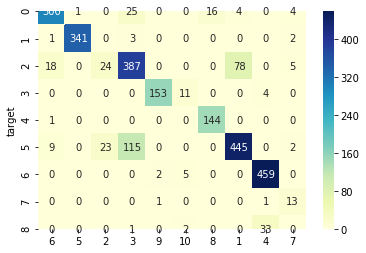

In [39]:
df_sc3 = reorder(df_sc3)
sns.heatmap(df_sc3, cmap="YlGnBu", annot=True, fmt="d")

In [40]:
df_cooc = pd.crosstab(cooc_data['target'], cooc_data[cooc_data['cooc_clusters']<20]['cooc_clusters'])
df_cooc_s = df_cooc.copy()
df_cooc_s["sum"] = df_cooc.sum(axis=1)
df_cooc_s

cooc_clusters,1,2,3,4,5,6,7,8,9,10,sum
target,,,,,,,,,,,
0,0,0,0,0,0,1,1,80,219,49,350
1,0,0,0,0,0,2,345,0,0,0,347
2,0,0,0,2,0,0,0,0,30,480,512
3,1,112,37,16,0,2,0,0,0,0,168
4,0,0,0,0,0,1,0,144,0,0,145
5,0,0,0,1,0,2,0,0,15,576,594
6,1,4,49,374,0,38,0,0,0,0,466
7,0,1,0,2,12,0,0,0,0,0,15
8,25,0,0,11,0,0,0,0,0,0,36


{1: 8, 2: 3, 3: 6, 4: 6, 5: 7, 6: 6, 7: 1, 8: 4, 9: 0, 10: 5}
[(9, 0), (7, 1), (2, 3), (8, 4), (10, 5), (3, 6), (4, 6), (6, 6), (5, 7), (1, 8)]


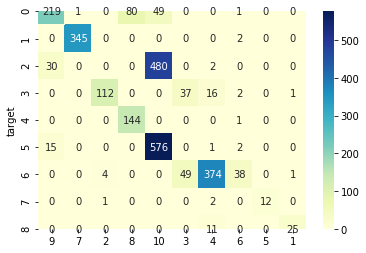

In [41]:
df_cooc = reorder(df_cooc)
sns.heatmap(df_cooc, cmap="YlGnBu", annot=True, fmt="d")

In [53]:
df_race = pd.crosstab(race_data['target'], race_data[ race_data['V1']<12]['V1'])
df_race_s = df_race.copy()
df_race_s["sum"] = df_race.sum(axis=1)
df_race_s

V1,1,2,3,4,5,6,7,8,9,10,11,sum
target,,,,,,,,,,,,
0,70,0,152,0,65,20,0,0,0,0,31,338
1,65,211,7,0,1,24,0,2,2,0,9,321
2,192,0,96,0,16,24,0,0,0,0,177,505
3,0,0,0,146,0,0,0,0,0,20,2,168
4,2,0,2,0,122,0,0,0,0,0,6,132
5,346,0,55,0,1,126,0,0,0,0,58,586
6,0,0,0,99,0,0,214,0,0,129,2,444
7,0,0,0,0,0,0,0,0,1,1,0,2
8,1,1,0,0,0,0,4,0,0,1,2,9


{1: 5, 2: 1, 3: 0, 4: 3, 5: 4, 6: 5, 7: 6, 8: 1, 9: 1, 10: 6, 11: 2}
[(3, 0), (2, 1), (8, 1), (9, 1), (11, 2), (4, 3), (5, 4), (1, 5), (6, 5), (7, 6), (10, 6)]


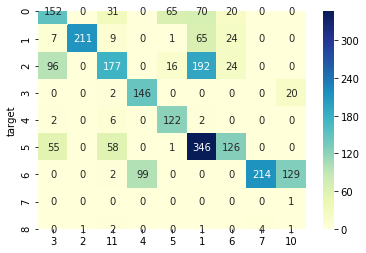

In [54]:
df_race = reorder(df_race)
df_race = df_race.drop(columns = [8,9])
sns.heatmap(df_race, cmap="YlGnBu", annot=True, fmt="d")